In [1]:
import gc
import os
import sys
import math
import random
import warnings
import pickle
from pathlib import Path
import copy
from joblib import Parallel, delayed

from functools import reduce
import pickle
from tqdm import tqdm
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from pandarallel import pandarallel
# pandarallel.initialize()
warnings.simplefilter("ignore")
import ctypes as ct
from datetime import timedelta
from sklearn.metrics import mean_absolute_error

# import mlb
import statistics as st
import lightgbm as lgbm
from scipy.stats import norm


In [2]:
# sys.path.append('../../')
# import src.utils as utils

In [3]:
OFFSET = 45
MAX_LAG = 27
LAGS = list(range(OFFSET, MAX_LAG + OFFSET))

In [4]:
DATA_DIR = Path("/home/knikaido/work/MLB-Player-Digital-Engagement-Forecasting/data/")
MAIN_DATA_DIR = DATA_DIR / 'mlb-player-digital-engagement-forecasting'
UPDATE_DATA_DIR = DATA_DIR / 'mlb-player-digital-engagement-forecasting-update'

BASE_DIR = MAIN_DATA_DIR
TRAIN_DIR = MAIN_DATA_DIR / 'train'

In [5]:
train_df = pd.read_csv(UPDATE_DATA_DIR / 'train_updated.csv').dropna(axis=1, how='all')

In [6]:
def expand_json_data(df, df_name):
    date_nested_table = df[['date', df_name]]

    date_nested_table = (
        date_nested_table[~pd.isna(date_nested_table[df_name])].reset_index(drop=True)
    )

    daily_dfs_collection = []

    for date_index, date_row in date_nested_table.iterrows():
        daily_df = pd.read_json(date_row[df_name])

        daily_df['dailyDataDate'] = date_row['date']

        daily_dfs_collection = daily_dfs_collection + [daily_df]

    # Concatenate all daily dfs into single df for each row
    unnested_table = (
        pd.concat(
            daily_dfs_collection,
            ignore_index = True
        ).set_index('dailyDataDate').reset_index()
    )
    
    return unnested_table

# reduce_mem_usage(unnested_table).to_pickle(f'{Config.data_dir}/{file}/{df_name}.pickle')

# del(date_nested_table, daily_dfs_collection, unnested_table)

In [7]:
scores = expand_json_data(train_df, 'playerBoxScores')
rosters = expand_json_data(train_df, 'rosters')

In [8]:
def make_last_days_df(df, column_name):

    players = pd.read_csv(BASE_DIR / 'players.csv')
    df_last_days = df[~df.duplicated(subset='playerId', keep='last')][['playerId', 'date']]
    df_last_days.columns = ['playerId', column_name]
#     players_test = players[players['playerForTestSetAndFuturePreds']==True]
    player_unique = pd.DataFrame(players['playerId'].unique(), columns=['playerId'])
    df_last_days = pd.merge(player_unique, df_last_days, on=['playerId'], how='left' )
    df_last_days = df_last_days.fillna(20171231)
    
    return df_last_days

In [9]:
scores['date'] = scores['dailyDataDate']
scores = scores.groupby(['playerId', 'date']).sum().reset_index()
rosters['date'] = rosters['dailyDataDate']

In [10]:
last_game_days = make_last_days_df(scores, 'lastdate')
last_roster_days = make_last_days_df(rosters, 'lastroster')

In [11]:
del scores, rosters

In [12]:
def extract_season(date_raw, season_start_end):
    idxes = 0
    for raw in season_start_end.iloc():
        idx_ = ((date_raw >= raw.iloc[0]) & (date_raw <= raw.iloc[1])) * 1
        idxes += idx_
    return idxes

In [13]:
class Rt4kaidoTest:
    def __init__(self, train_features_dict, models_notgameday, models_gameday, usetimelinefeature=False):
        
        self.usetimelinefeature = usetimelinefeature
        self.train_features_dict = train_features_dict
        self.feature_cols1 = train_features_dict['feature_cols1']
        self.feature_cols2 = train_features_dict['feature_cols2']
        self.feature_cols3 = train_features_dict['feature_cols3']
        self.feature_cols4 = train_features_dict['feature_cols4']
        self.models_notgameday = models_notgameday
        self.models_gameday = models_gameday


        self.test_players_cols = ['playerId', 'primaryPositionName', 'birthCity', 'DOY', 'mlbDebutYear', 'mlbDebutDate', 'DebutAge', 'heightInches', 'weight']
        self.test_rosters_cols = ['date', 'playerId', 'teamId', 'status']
        self.test_standings_cols = ['date','teamId', 'wildCardRank', 'sportGamesBack']
        self.test_scores_cols = ['date','playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
               'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
               'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
               'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
               'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
               'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
               'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
               'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
               'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
               'groundOutsPitching', 'runsPitching', 'doublesPitching',
               'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
               'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
               'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
               'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
               'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
               'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
               'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
               'inheritedRunnersScored', 'catchersInterferencePitching',
               'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
               'assists', 'putOuts', 'errors', 'chances', 'gamePk']
        

    def test_oneline(self, test_df, sample_prediction_df):
        
        null = np.nan
        true = True
        false = False
        
        sample_prediction_df = sample_prediction_df.reset_index(drop=True)
        test_date = test_df.index[0]

        # creat dataset
        date_and_playerId = sample_prediction_df['date_playerId'].str.split('_', expand=True)
        sample_prediction_df['playerId'] = date_and_playerId[1].astype(int)
        sample_prediction_df['date'] = test_date
        
        # Dealing with missing values
        if test_df['rosters'].iloc[0] == test_df['rosters'].iloc[0]:
            test_rosters = pd.DataFrame(eval(test_df['rosters'].iloc[0]))
        else:
            test_rosters = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
            for col in self.train_features_dict['rosters_cols_all']:
                if col == 'playerId': continue
                test_rosters[col] = np.nan
        test_rosters['date'] = test_date

        if test_df['playerBoxScores'].iloc[0] == test_df['playerBoxScores'].iloc[0]:
            test_scores = pd.DataFrame(eval(test_df['playerBoxScores'].iloc[0]))
            test_scores = test_scores.groupby('playerId').sum().reset_index()
        else:
            test_scores = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
            for col in self.train_features_dict['scores_cols_all']:
                if col == 'playerId': continue
                test_scores[col] = np.nan
        test_scores['date'] = test_date
              
        test = sample_prediction_df[['playerId', 'date']].copy()
        test = test.merge(self.train_features_dict['players'][self.test_players_cols], on='playerId', how='left')
        test = test.merge(test_rosters[self.test_rosters_cols], on=['playerId', 'date'], how='left')
        test = test.merge(test_scores[self.test_scores_cols], on=['playerId', 'date'], how='left')
        test = test.merge(self.train_features_dict['player_target_stats'], how='left', left_on=["playerId"],right_on=["playerId"])

        if test_df['standings'].iloc[0] == test_df['standings'].iloc[0]:
            test_standings = pd.DataFrame(eval(test_df['standings'].iloc[0]))
        else:
            test_standings = pd.DataFrame({'teamId': test['teamId'].unique()})
            for col in self.train_features_dict['standings_cols_all']:
                if col == 'teamId': continue
                test_standings[col] = np.nan   
        test_standings['date'] = test_date

        
        test = test.merge(test_standings[self.test_standings_cols], on=['teamId', 'date'], how='left')
        test = test.merge(self.train_features_dict['team_target_stats'], how='left', left_on=["teamId"],right_on=["playerId"], suffixes=('', 'team_'))
        test['wildCardRank'] = test['wildCardRank'].astype(float)


        test['label_playerId'] = test['playerId'].map(self.train_features_dict['player2num'])
        test['label_primaryPositionName'] = test['primaryPositionName'].map(self.train_features_dict['position2num'])
        test['label_teamId'] = test['teamId'].map(self.train_features_dict['teamid2num'])
        test['label_status'] = test['status'].map(self.train_features_dict['status2num'])
        test['label_birthCity'] = test['birthCity'].map(self.train_features_dict['birthCityn2num'])
        test['mlbDebutDateflag'] = (test['mlbDebutDate'] == test['date']) * 1
        test['sincemlbDebutDateflag'] = (test['date'] >= test['mlbDebutDate']) * 1
        test['diffmlbDebutDateflag'] = (test['date'] - test['mlbDebutDate'])

        date_ = pd.to_datetime(test_df.index[0], format="%Y%m%d")
        test['annual_day'] = (date_ - pd.to_datetime(date_.year, format="%Y")) /  timedelta(days=1)
        test['week_day'] = date_.weekday()
        test['month'] = date_.month
        
        
        ## season_info
        on_preseason_idxes = extract_season(test['date'], self.train_features_dict['seasons'][['preSeasonStartDate', 'preSeasonEndDate']])
        on_season_idxes = extract_season(test['date'], self.train_features_dict['seasons'][['regularSeasonStartDate', 'regularSeasonEndDate']]) * 2
        on_postseason_idxes = extract_season(test['date'], self.train_features_dict['seasons'][['postSeasonStartDate', 'postSeasonEndDate']]) * 3

        special_days = self.train_features_dict['seasons']['lastDate1stHalf'].to_list() + self.train_features_dict['seasons']['allStarDate'].to_list() + self.train_features_dict['seasons']['firstDate2ndHalf'].to_list()
        special_idxes = 0
        for day in special_days:
            special_idxes += (test['date'] == day) * 4

        on_total_season_idxes = on_preseason_idxes
        on_total_season_idxes[on_season_idxes==2] = 2
        on_total_season_idxes[on_postseason_idxes==3] = 3
        on_total_season_idxes[special_idxes==4] = 4

        test['season_info'] = on_total_season_idxes
             
            
        if self.usetimelinefeature:
            
            test['gameday'] = ~test['battingOrder'].isna()*1
            test = pd.merge(test, self.train_features_dict['train_last_game'], on=['playerId'], how='left')
            test['daysSinceLastGame'] = (pd.to_datetime(test['date'], format="%Y%m%d") - pd.to_datetime(test['lastdate'], format="%Y%m%d")).dt.days
            test.loc[test['gameday']==1,'daysSinceLastGame']=0
            
            self.train_features_dict['train_last_game'] = pd.merge(self.train_features_dict['train_last_game'], test[test['gameday']==1][['playerId','date']], on=['playerId'], how='left')
            self.train_features_dict['train_last_game']['lastdate'].update(self.train_features_dict['train_last_game']['date'])
            self.train_features_dict['train_last_game'] = self.train_features_dict['train_last_game'][['playerId', 'lastdate']]
                        
            test['rosterday'] = ~test['status'].isna()*1
            test = pd.merge(test, self.train_features_dict['train_last_roster'], on=['playerId'], how='left')
            test['daysSinceLastRoster'] = (pd.to_datetime(test['date'], format="%Y%m%d") - pd.to_datetime(test['lastroster'], format="%Y%m%d")).dt.days
            test.loc[test['rosterday']==1,'daysSinceLastRoster']=0
            
            self.train_features_dict['train_last_roster'] = pd.merge(self.train_features_dict['train_last_roster'], test[test['rosterday']==1][['playerId','date']], on=['playerId'], how='left')
            self.train_features_dict['train_last_roster']['lastroster'].update(self.train_features_dict['train_last_roster']['date'])
            self.train_features_dict['train_last_roster'] = self.train_features_dict['train_last_roster'][['playerId', 'lastroster']]
            
        test_gameday = test[test['gameday']==1]
        
        self.test = test

        if len(test_gameday) != 0:
            gameday_index = list(test_gameday.index)

            test_X = test.iloc[gameday_index]
            

            pred1 = self.models_gameday[0][4].predict(test_X[self.feature_cols1])
            pred2 = self.models_gameday[1][4].predict(test_X[self.feature_cols2])
            pred3 = self.models_gameday[2][4].predict(test_X[self.feature_cols3])
            pred4 = self.models_gameday[3][4].predict(test_X[self.feature_cols4])

            # merge submission
            sample_prediction_df['target1'].iloc[gameday_index] = pred1
            sample_prediction_df['target2'].iloc[gameday_index] = pred2
            sample_prediction_df['target3'].iloc[gameday_index] = pred3
            sample_prediction_df['target4'].iloc[gameday_index] = pred4

        # ------------------------------------------------------------

        test_notgameday = test[test['gameday']==0]
        if len(test_notgameday) != 0:
            notgameday_index = list(test_notgameday.index)

            test_X = test.iloc[notgameday_index]

            pred1 = self.models_notgameday[0][4].predict(test_X[self.feature_cols1])
            pred2 = self.models_notgameday[1][4].predict(test_X[self.feature_cols2])
            pred3 = self.models_notgameday[2][4].predict(test_X[self.feature_cols3])
            pred4 = self.models_notgameday[3][4].predict(test_X[self.feature_cols4])

            # merge submission
            sample_prediction_df['target1'].iloc[notgameday_index] = pred1
            sample_prediction_df['target2'].iloc[notgameday_index] = pred2
            sample_prediction_df['target3'].iloc[notgameday_index] = pred3
            sample_prediction_df['target4'].iloc[notgameday_index] = pred4

        sample_prediction_df = sample_prediction_df.fillna(0.)
        
        sample_prediction_df['target1'] = np.clip(sample_prediction_df['target1'], 0, 100)
        sample_prediction_df['target2'] = np.clip(sample_prediction_df['target2'], 0, 100)
        sample_prediction_df['target3'] = np.clip(sample_prediction_df['target3'], 0, 100)
        sample_prediction_df['target4'] = np.clip(sample_prediction_df['target4'], 0, 100)

        del sample_prediction_df['playerId']
        del sample_prediction_df['date']

        
        return sample_prediction_df

## Inference

In [14]:
# 新しいtrain_update, players, nextDayPlayerEngagementの展開されたものを読み込める必要あり

class LocalTest:
    def __init__(self, start_day, end_day):
        self.start_day = start_day
        self.end_day = end_day
        
    def make_env(self):
    
        self.original_data = pd.read_csv(UPDATE_DATA_DIR / "train_updated.csv")
        self.original_data = self.original_data[(self.original_data['date'] >= self.start_day) & (self.original_data['date'] <= self.end_day)].reset_index(drop=True)
        
        test_players = pd.read_csv(UPDATE_DATA_DIR / 'players.csv')
        self.players_test = test_players[test_players['playerForTestSetAndFuturePreds']==True]['playerId'].unique()
        
        self.test_targets = pd.read_csv(UPDATE_DATA_DIR / 'train/nextDayPlayerEngagement_train.csv')
        self.test_targets = self.test_targets[(self.test_targets['date'] >= self.start_day) & (self.test_targets['date'] <= self.end_day) & (self.test_targets['playerId'].isin(self.players_test))].reset_index(drop=True)
        
        self.scores = []
        return self
        
    def iter_test(self):
        self.num = len(self.original_data['date'].unique())
        self.current = 0
        self.predict_flag = True
        
        return self
    
    def __iter__(self):
        return self

    def __next__(self):
        assert self.predict_flag == True, 'You must call `predict()` successfully before you can continue with `iter_test()`'
     
        if self.current == self.num:
            print(np.mean(self.scores))
            raise StopIteration()

        test_df = self.original_data.iloc[self.current:self.current+1].set_index('date')

        sample_prediction_df = pd.DataFrame()
        sample_prediction_df['date'] = [test_df.index[0]] * len(self.players_test)
        next_day = (pd.to_datetime(sample_prediction_df['date'], format="%Y%m%d") + timedelta(days=1)).astype(str).str.replace('-', '')
        # next_day.str.cat(players_test.astype(str))
        sample_prediction_df['date_playerId'] = [next_day[0] + '_' + str(p_) for p_ in self.players_test]
        sample_prediction_df['target1'] = 0
        sample_prediction_df['target2'] = 0
        sample_prediction_df['target3'] = 0
        sample_prediction_df['target4'] = 0

        sample_prediction_df = sample_prediction_df.set_index('date')

        self.current += 1
        self.predict_flag = False
        return test_df, sample_prediction_df
    
    def predict(self, sample_prediction_df):
        
        assert list(sample_prediction_df.columns) == ['date_playerId', 'target1', 'target2', 'target3', 'target4'], 'columns miss.'
        self.predict_flag = True
    
        sample_prediction_df = sample_prediction_df.reset_index()
        date_playerId = sample_prediction_df['date_playerId'].str.split('_', expand=True)
        sample_prediction_df['date'] = (pd.to_datetime(date_playerId[0], format="%Y%m%d") + timedelta(days=-1)).astype(str).str.replace('-', '').values.astype(int)
        sample_prediction_df['playerId'] = date_playerId[1].values.astype(int)
        target_oneday = pd.merge(sample_prediction_df, self.test_targets, how='left', on=['date', 'playerId'], suffixes=('', '_true'))
        score = mean_absolute_error(target_oneday.loc[:, 'target1':'target4'], target_oneday.loc[:, 'target1_true':'target4_true'])
        
        self.scores.append(score)


In [29]:
with open("../78/output/train_features_dict78.pickle", mode="rb") as f:
    train_features_dict = pickle.load(f)
    
with open('../78/output/models78.pickle', mode="rb") as f:
    models = pickle.load(f)
    
# with open('../78/output/models78_gameday.pickle', mode="rb") as f:
#     models_gameday = pickle.load(f)


In [30]:
train_features_dict['train_last_game'] = last_game_days
train_features_dict['train_last_roster'] = last_roster_days

## self.train_features_dict['train_last_roster']が更新されちゃうから，これは絶対呼ぶ
rt4kaido_test = Rt4kaidoTest(train_features_dict, models, models, usetimelinefeature=True)

In [31]:
mlb = LocalTest(20210501, 20210531)
env = mlb.make_env() # initialize the environment
iter_test = env.iter_test() # iterator which loops over each date in test set

In [32]:
sample_prediction_dfs = []
for (test_df, sample_prediction_df) in tqdm(iter_test): # make predictions here
    
    sample_prediction_df = rt4kaido_test.test_oneline(test_df, sample_prediction_df)
    env.predict(sample_prediction_df)   
    
    test_date = test_df.index[0]
    date_and_playerId = sample_prediction_df['date_playerId'].str.split('_', expand=True)
    sample_prediction_df['playerId'] = date_and_playerId[1].astype(int)
    sample_prediction_df['date'] = test_date
    sample_prediction_dfs.append((sample_prediction_df))
    
#     if test_df['playerBoxScores'].iloc[0] != test_df['playerBoxScores'].iloc[0]:
#         print(test_df.index[0])

31it [00:07,  3.93it/s]

1.3292315478442125


5月 1.2815181343261905
4月 1.2991224262632444


In [33]:
1.2812491056533517


1.2812491056533517

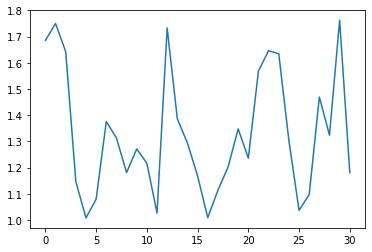

In [34]:
plt.plot(iter_test.scores)

In [22]:
targets = pd.read_csv(UPDATE_DATA_DIR / 'train/nextDayPlayerEngagement_train.csv')

In [23]:
# creat dataset
sample_prediction_dfs = pd.concat(sample_prediction_dfs)

In [24]:
sample_prediction_df_ = pd.merge(sample_prediction_dfs, targets, on=['playerId', 'date'], how='left')

,count,mean,std,min,25%,50%,75%,max
target2_x,36797.0,2.469257,3.330705,0.012132,0.622779,1.300503,2.987653,32.547067


,count,mean,std,min,25%,50%,75%,max
target2_y,36797.0,3.177256,7.222521,0.0,0.298591,0.940884,3.011959,100.0


2.1338248290704365

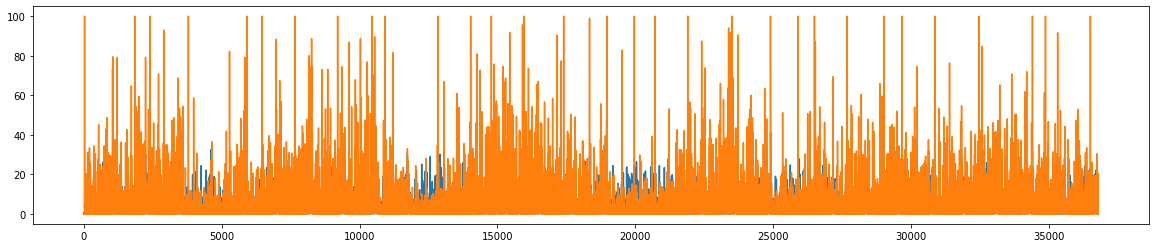

In [25]:
plt.figure(figsize=(20, 4))
plt.plot(sample_prediction_df_['target2_x'])
plt.plot(sample_prediction_df_['target2_y'])
display(pd.DataFrame(sample_prediction_df_['target2_x']).describe().T)
display(pd.DataFrame(sample_prediction_df_['target2_y']).describe().T)
mean_absolute_error(sample_prediction_df_['target2_y'], sample_prediction_df_['target2_x'])

In [26]:
print(mean_absolute_error(sample_prediction_df_[['target1_y', 'target2_y', 'target3_y', 'target4_y']], sample_prediction_df_[['target1_x', 'target2_x', 'target3_x', 'target4_x']]))
print(mean_absolute_error(sample_prediction_df_['target1_y'], sample_prediction_df_['target1_x']))
print(mean_absolute_error(sample_prediction_df_['target2_y'], sample_prediction_df_['target2_x']))
print(mean_absolute_error(sample_prediction_df_['target3_y'], sample_prediction_df_['target3_x']))
print(mean_absolute_error(sample_prediction_df_['target4_y'], sample_prediction_df_['target4_x']))

1.3292315478442127
1.0874085252535661
2.1338248290704365
0.8715159860740906
1.2241768509787576
